In [2]:
import pandas as pd

In [3]:
df_merged_3 = pd.read_csv('./data/merged4.csv')
df_merged_3_std = pd.read_csv('./data/merged4_std.csv')
df_merged_3_std_dummy = pd.read_csv('./data/merged4_std_dummy.csv')


In [25]:
len(df_merged_3_std_dummy)

1299

In [15]:
df_merged_3_std_dummy.head(2)

,isbn,title,publisher_alligator,publisher_amulet_books,publisher_autumn,publisher_b_e_s_pub_co,"publisher_bridge_publications,_inc.",publisher_cartwheel_books,publisher_cornerstone_leadership_institute,publisher_creative_teaching_pr,...,print_length,item_weight,length,width,height,rating,number_of_reviews,price,best_sellers_rank,customer_reviews
0,9780062381910,My Five Senses (Let's-Read-and-Find-Out Scienc...,0,0,0,0,0,0,0,0,...,-0.30960,-0.150662,0.44464,0.677013,-0.416790,0.529758,-0.087224,-0.063596,-0.751032,0.529758
1,9781409305996,Peppa Pig: Peppa Plays Football,0,0,0,0,0,0,0,0,...,-0.40469,-0.939640,-0.44869,0.627478,-0.841456,-0.042785,-0.244645,-0.361644,NaN,-0.042785


In [7]:
df_merged_3_std_dummy.columns

Index(['isbn', 'title', 'publisher_alligator', 'publisher_amulet_books',
       'publisher_autumn', 'publisher_b_e_s_pub_co',
       'publisher_bridge_publications,_inc.', 'publisher_cartwheel_books',
       'publisher_cornerstone_leadership_institute',
       'publisher_creative_teaching_pr', 'publisher_creative_teaching_press',
       'publisher_dean_&_son', 'publisher_egmont', 'publisher_five_mile',
       'publisher_gardners_vi_books_ams006', 'publisher_graphix',
       'publisher_guinness_world_records', 'publisher_harry_n._abrams',
       'publisher_hinkler', 'publisher_hot_methods,_inc.', 'publisher_igloo',
       'publisher_independently_published', 'publisher_kingfisher',
       'publisher_kumon', 'publisher_ladybird',
       'publisher_macmillan_childrens', 'publisher_make_believe_ideas',
       'publisher_papercutz', 'publisher_parkwest_publications',
       'publisher_parragon', 'publisher_penguin_random_house',
       'publisher_phidal', 'publisher_phoenix_international',


## AutoEncoder

In [4]:
len(df_merged_3_std_dummy.columns)

64

In [8]:
# Cell 1: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [16]:
# model
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=20):
        super(VariationalAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc_mu = nn.Linear(64, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(64, latent_dim)  # Log variance
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, input_dim),
            # No activation on final layer for reconstruction
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

In [17]:
# Cell 3: Data preprocessing function
def load_and_preprocess_data(file_path):
    """Load and preprocess the data with mixed data types"""
    # Load data
    df = pd.read_csv(file_path)
    print(f"Original data shape: {df.shape}")
    print(f"Original columns: {df.columns.tolist()}")
    print(f"Data types:\n{df.dtypes}")
    
    # Create a copy for preprocessing
    df_processed = df.copy()
    
    # Identify numeric and categorical columns
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    
    print(f"\nNumeric columns ({len(numeric_cols)}): {numeric_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    
    # Handle categorical columns
    encoders = {}
    if categorical_cols:
        # Use one-hot encoding for categorical variables
        onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        categorical_encoded = onehot_encoder.fit_transform(df_processed[categorical_cols])
        
        # Create column names for one-hot encoded features
        categorical_feature_names = []
        for i, col in enumerate(categorical_cols):
            for category in onehot_encoder.categories_[i]:
                categorical_feature_names.append(f"{col}_{category}")
        
        # Create DataFrame for encoded categorical features
        categorical_df = pd.DataFrame(categorical_encoded, columns=categorical_feature_names)
        
        # Combine numeric and encoded categorical features
        numeric_df = df_processed[numeric_cols]
        df_processed = pd.concat([numeric_df, categorical_df], axis=1)
        encoders['onehot'] = onehot_encoder
    else:
        encoders['onehot'] = None
    
    print(f"Processed data shape: {df_processed.shape}")
    
    # Handle missing values
    if df_processed.isnull().sum().sum() > 0:
        print(f"Missing values found: {df_processed.isnull().sum().sum()}")
        df_processed = df_processed.fillna(df_processed.mean())
    
    # Convert to numpy array
    X = df_processed.values.astype(np.float32)
    
    # Split into train and test
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\nFinal training data shape: {X_train_scaled.shape}")
    print(f"Final test data shape: {X_test_scaled.shape}")
    
    return X_train_scaled, X_test_scaled, scaler, encoders, df_processed.columns.tolist()

In [18]:
# Cell 4: Create DataLoaders
def create_dataloaders(X_train, X_test, batch_size=32):
    """Create PyTorch DataLoaders"""
    # Convert to PyTorch tensors
    train_tensor = torch.FloatTensor(X_train)
    test_tensor = torch.FloatTensor(X_test)
    
    # Create datasets (for autoencoder, input = target)
    train_dataset = TensorDataset(train_tensor, train_tensor)
    test_dataset = TensorDataset(test_tensor, test_tensor)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Cell 5: Training function
def train_autoencoder(model, train_loader, test_loader, num_epochs=100):
    """Train the autoencoder"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    test_losses = []
    
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Testing phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        # Update learning rate
        scheduler.step(avg_test_loss)
        
        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}, LR: {current_lr:.6f}')
    
    return train_losses, test_losses

# Cell 6: Evaluation function
def evaluate_reconstruction(model, test_loader, scaler, original_columns):
    """Evaluate the quality of reconstruction"""
    model.eval()
    reconstructions = []
    originals = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            reconstructions.append(output.cpu().numpy())
            originals.append(target.numpy())
    
    # Concatenate all batches
    reconstructions = np.vstack(reconstructions)
    originals = np.vstack(originals)
    
    # Inverse transform to original scale
    reconstructions_original = scaler.inverse_transform(reconstructions)
    originals_original = scaler.inverse_transform(originals)
    
    # Calculate reconstruction error
    mse = np.mean((reconstructions_original - originals_original) ** 2)
    mae = np.mean(np.abs(reconstructions_original - originals_original))
    
    print(f"\n=== Reconstruction Quality ===")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    
    # Calculate relative error (as percentage of feature ranges)
    feature_ranges = np.ptp(originals_original, axis=0)
    feature_ranges[feature_ranges == 0] = 1  # Avoid division by zero
    relative_errors = np.mean(np.abs(reconstructions_original - originals_original), axis=0) / feature_ranges
    print(f"Average relative error: {np.mean(relative_errors):.4f} ({np.mean(relative_errors)*100:.2f}%)")
    
    # Show worst reconstructed features
    feature_errors = np.mean(np.abs(reconstructions_original - originals_original), axis=0)
    worst_features_idx = np.argsort(feature_errors)[-5:][::-1]  # Top 5 worst
    print(f"\nWorst reconstructed features:")
    for idx in worst_features_idx:
        if idx < len(original_columns):
            print(f"  {original_columns[idx]}: {feature_errors[idx]:.4f}")
    
    return reconstructions_original, originals_original, mse, mae

In [19]:
# Cell 7: Visualization function
def plot_results(train_losses, test_losses, reconstructions, originals, n_samples=3):
    """Plot training history and sample reconstructions"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training history
    axes[0,0].plot(train_losses, label='Training Loss')
    axes[0,0].plot(test_losses, label='Test Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss (MSE)')
    axes[0,0].set_title('Autoencoder Training History')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Plot sample reconstructions
    sample_idx = np.random.randint(0, len(reconstructions), n_samples)
    for i, idx in enumerate(sample_idx):
        axes[0,1].plot(originals[idx], 'b-', alpha=0.7, label='Original' if i == 0 else "")
        axes[0,1].plot(reconstructions[idx], 'r--', alpha=0.7, label='Reconstructed' if i == 0 else "")
    
    axes[0,1].set_xlabel('Feature Index')
    axes[0,1].set_ylabel('Feature Value')
    axes[0,1].set_title('Sample Reconstructions (3 random samples)')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Plot reconstruction error distribution
    errors = np.mean(np.abs(reconstructions - originals), axis=1)
    axes[1,0].hist(errors, bins=50, alpha=0.7, color='green')
    axes[1,0].set_xlabel('Mean Absolute Error per Sample')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Reconstruction Error Distribution')
    axes[1,0].grid(True)
    
    # Plot feature-wise errors
    feature_errors = np.mean(np.abs(reconstructions - originals), axis=0)
    axes[1,1].plot(feature_errors, 'o-', alpha=0.7)
    axes[1,1].set_xlabel('Feature Index')
    axes[1,1].set_ylabel('Mean Absolute Error')
    axes[1,1].set_title('Feature-wise Reconstruction Errors')
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

Loading and preprocessing data...
Original data shape: (1299, 64)
Original columns: ['isbn', 'title', 'publisher_alligator', 'publisher_amulet_books', 'publisher_autumn', 'publisher_b_e_s_pub_co', 'publisher_bridge_publications,_inc.', 'publisher_cartwheel_books', 'publisher_cornerstone_leadership_institute', 'publisher_creative_teaching_pr', 'publisher_creative_teaching_press', 'publisher_dean_&_son', 'publisher_egmont', 'publisher_five_mile', 'publisher_gardners_vi_books_ams006', 'publisher_graphix', 'publisher_guinness_world_records', 'publisher_harry_n._abrams', 'publisher_hinkler', 'publisher_hot_methods,_inc.', 'publisher_igloo', 'publisher_independently_published', 'publisher_kingfisher', 'publisher_kumon', 'publisher_ladybird', 'publisher_macmillan_childrens', 'publisher_make_believe_ideas', 'publisher_papercutz', 'publisher_parkwest_publications', 'publisher_parragon', 'publisher_penguin_random_house', 'publisher_phidal', 'publisher_phoenix_international', 'publisher_price_ste

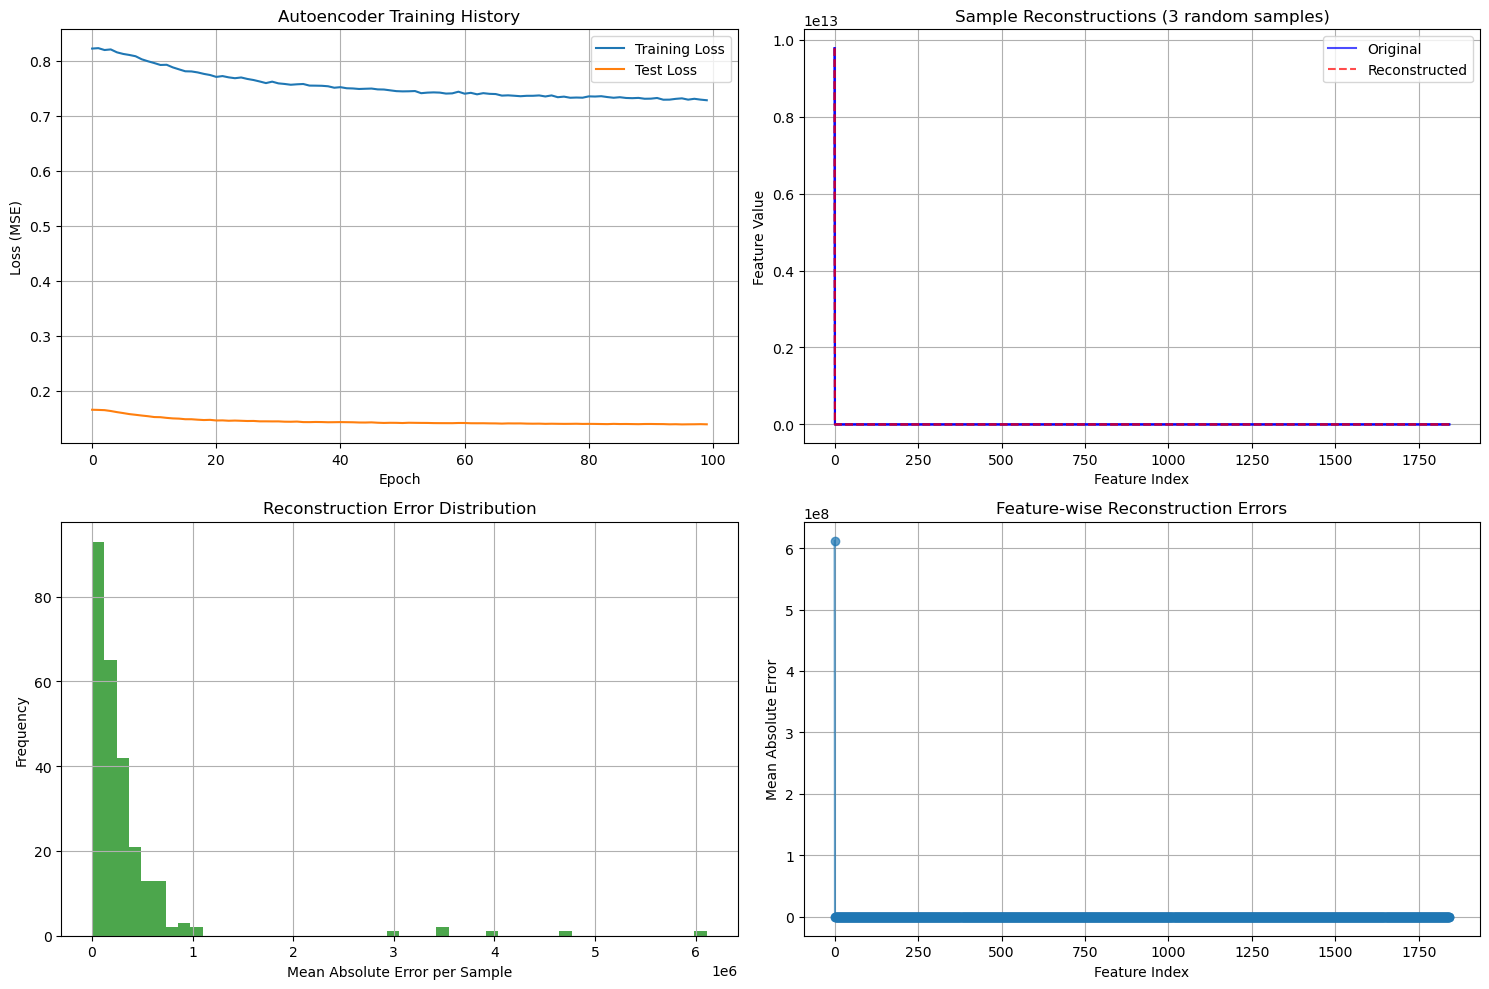


Model saved as 'autoencoder_model.pth'

=== Encoding Demonstration ===
Original feature dimension: 1842
Encoded vector dimension: 32
Sample encoded vectors shape: torch.Size([3, 32])
First encoded sample: [-0.5209109  -0.96151114  2.2289042  -2.3596487  -2.4362025  -1.4184046
 -3.6196969  -1.7519778   1.9959056   3.8778498 ]


In [23]:
# Cell 8: Main execution cell
print("Loading and preprocessing data...")
X_train, X_test, scaler, encoders, feature_columns = load_and_preprocess_data("./data/merged4_std_dummy.csv")

# Create data loaders
batch_size = 32
train_loader, test_loader = create_dataloaders(X_train, X_test, batch_size)

# Initialize autoencoder
input_dim = X_train.shape[1]
encoding_dim = min(32, input_dim // 4)  # Adaptive encoding dimension
model = Autoencoder(input_dim, encoding_dim)

print(f"\n=== Autoencoder Architecture ===")
print(f"Input dimension: {input_dim}")
print(f"Encoding dimension: {encoding_dim}")
print(f"Compression ratio: {input_dim/encoding_dim:.2f}:1")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train the autoencoder
print("\n=== Training Autoencoder ===")
train_losses, test_losses = train_autoencoder(model, train_loader, test_loader, num_epochs=100)

# Evaluate reconstruction quality
reconstructions, originals, mse, mae = evaluate_reconstruction(
    model, test_loader, scaler, feature_columns
)

# Plot results
plot_results(train_losses, test_losses, reconstructions, originals)

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'encoders': encoders,
    'input_dim': input_dim,
    'encoding_dim': encoding_dim,
    'feature_columns': feature_columns
}, 'autoencoder_model.pth')

print("\nModel saved as 'autoencoder_model.pth'")

# Demonstrate encoding capability
print("\n=== Encoding Demonstration ===")
sample_data = torch.FloatTensor(X_test[:3]).to(device)
encoded_vectors = model.encode(sample_data)
print(f"Original feature dimension: {input_dim}")
print(f"Encoded vector dimension: {encoding_dim}")
print(f"Sample encoded vectors shape: {encoded_vectors.shape}")
print(f"First encoded sample: {encoded_vectors[0][:10].cpu().detach().numpy()}")  # Show first 10 values

## Evaluate AutoEncoder

In [ ]:
# Cell 9: Quantitative Evaluation
def calculate_quality_metrics(originals, reconstructions, original_data):
    """Calculate comprehensive quality metrics"""
    
    # 1. Basic error metrics
    mse = np.mean((reconstructions - originals) ** 2)
    mae = np.mean(np.abs(reconstructions - originals))
    
    # 2. Relative to data scale
    data_range = np.ptp(original_data, axis=0)
    data_range[data_range == 0] = 1  # Avoid division by zero
    relative_error = np.mean(np.abs(reconstructions - originals) / data_range)
    
    # 3. Variance explained
    total_variance = np.var(originals, axis=0).sum()
    error_variance = np.var(reconstructions - originals, axis=0).sum()
    variance_explained = 1 - (error_variance / total_variance)
    
    # 4. Correlation preservation
    original_corrs = np.corrcoef(originals.T)
    reconstructed_corrs = np.corrcoef(reconstructions.T)
    correlation_preservation = np.corrcoef(original_corrs.flatten(), 
                                         reconstructed_corrs.flatten())[0,1]
    
    print("=== AUTOENCODER QUALITY BENCHMARKS ===")
    print(f"1. Basic Metrics:")
    print(f"   - MSE: {mse:.4f}")
    print(f"   - MAE: {mae:.4f}")
    print(f"   - Relative Error: {relative_error:.3f} ({relative_error*100:.1f}%)")
    
    print(f"\n2. Information Preservation:")
    print(f"   - Variance Explained: {variance_explained:.3f}")
    print(f"   - Correlation Preservation: {correlation_preservation:.3f}")
    
    print(f"\n3. Business Readiness:")
    if variance_explained > 0.85 and relative_error < 0.08:
        print("   ✅ EXCELLENT - Ready for production use")
    elif variance_explained > 0.70 and relative_error < 0.15:
        print("   ✅ GOOD - Suitable for most applications")
    elif variance_explained > 0.50 and relative_error < 0.25:
        print("   ⚠️  ACCEPTABLE - May need feature selection first")
    else:
        print("   ❌ POOR - Consider simplifying features or getting more data")
    
    return {
        'mse': mse, 'mae': mae, 'relative_error': relative_error,
        'variance_explained': variance_explained,
        'correlation_preservation': correlation_preservation
    }

# Run the evaluation


In [ ]:
# Run the evaluationzzz
# quality_metrics = calculate_quality_metrics(originals, reconstructions, X_test)

=== AUTOENCODER QUALITY BENCHMARKS ===
1. Basic Metrics:
   - MSE: 759928159469568.0000
   - MAE: 283103.6250
   - Relative Error: 48361.023 (4836102.3%)

2. Information Preservation:
   - Variance Explained: 0.834
   - Correlation Preservation: nan

3. Business Readiness:
   ❌ POOR - Consider simplifying features or getting more data


In [24]:
quality_metrics = calculate_quality_metrics(originals, reconstructions, X_test)

=== AUTOENCODER QUALITY BENCHMARKS ===
1. Basic Metrics:
   - MSE: 951199763267584.0000
   - MAE: 332250.5000
   - Relative Error: 56698.055 (5669805.5%)

2. Information Preservation:
   - Variance Explained: 0.782
   - Correlation Preservation: nan

3. Business Readiness:
   ❌ POOR - Consider simplifying features or getting more data


# Run the evaluation
quality_metrics = calculate_quality_metrics(originals, reconstructions, X_test)

# Re-try

In [18]:
# Cell 2: Enhanced Autoencoder class
class EnhancedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=64):  # Increased encoding dim
        super(EnhancedAutoencoder, self).__init__()
        
        # Encoder - Deeper architecture
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            
            nn.Linear(64, encoding_dim),  # Bottleneck
        )
        
        # Decoder - Symmetric architecture
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.LeakyReLU(0.2),
            
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

In [19]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=64, noise_factor=0.2):
        super(DenoisingAutoencoder, self).__init__()
        self.noise_factor = noise_factor
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, encoding_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, input_dim),
        )
    
    def add_noise(self, x):
        """Add random noise to input for denoising"""
        noise = torch.randn_like(x) * self.noise_factor
        return x + noise
    
    def forward(self, x):
        # Add noise during training only
        if self.training:
            x = self.add_noise(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

In [20]:
# Cell 5: Enhanced training function
def train_enhanced_autoencoder(model, train_loader, test_loader, num_epochs=200):
    """Enhanced training with better optimization"""
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Enhanced learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=20, T_mult=2, eta_min=1e-6
    )
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience = 20
    patience_counter = 0
    
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            
            # Add L1 regularization for sparsity
            l1_lambda = 0.0001
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Testing phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        # Early stopping
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_autoencoder.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # Update learning rate
        scheduler.step()
        
        if (epoch + 1) % 20 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}, LR: {current_lr:.6f}')
    
    # Load best model
    model.load_state_dict(torch.load('best_autoencoder.pth'))
    return train_losses, test_losses

In [21]:
# Cell 2.5: Feature Analysis and Selection
def analyze_and_select_features(X_train, X_test, feature_columns, variance_threshold=0.01):
    """Remove low-variance features that hurt autoencoder performance"""
    from sklearn.feature_selection import VarianceThreshold
    
    # Calculate feature variances
    feature_variances = np.var(X_train, axis=0)
    
    # Remove low-variance features
    selector = VarianceThreshold(threshold=variance_threshold)
    X_train_selected = selector.fit_transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature indices
    selected_indices = selector.get_support(indices=True)
    selected_columns = [feature_columns[i] for i in selected_indices]
    
    print(f"Original features: {X_train.shape[1]}")
    print(f"Selected features: {X_train_selected.shape[1]}")
    print(f"Removed {X_train.shape[1] - X_train_selected.shape[1]} low-variance features")
    
    # Show top features by variance
    print("\nTop 10 features by variance:")
    for i in np.argsort(feature_variances)[-10:][::-1]:
        if i < len(feature_columns):
            print(f"  {feature_columns[i]}: {feature_variances[i]:.4f}")
    
    return X_train_selected, X_test_selected, selected_columns

# Use this in your main cell:
print("Analyzing and selecting features...")
X_train_selected, X_test_selected, selected_columns = analyze_and_select_features(
    X_train, X_test, feature_columns
)

Analyzing and selecting features...
Original features: 1842
Selected features: 1514
Removed 328 low-variance features

Top 10 features by variance:
  publication_date_2010-06-01: 1.0000
  publication_date_2024-06-24: 1.0000
  title_HowExpert Guide to Evangelism: A Comprehensive Manual for Spreading the Gospel with Passion, Purpose, and Practical Strategies: 1.0000
  publication_date_2016-12-20: 1.0000
  publication_date_2011-04-01: 1.0000
  publication_date_2018-04-24: 1.0000
  publication_date_1984-10-12: 1.0000
  publication_date_2015-05-05: 1.0000
  publication_date_1987-10-12: 1.0000
  publication_date_2017-05-01: 1.0000


In [24]:
# Cell 8 (Updated): Enhanced main execution
print("Loading and preprocessing data...")
X_train, X_test, scaler, encoders, feature_columns = load_and_preprocess_data("./data/merged4_std_dummy.csv")

# Feature selection
print("\n=== Feature Selection ===")
X_train_selected, X_test_selected, selected_columns = analyze_and_select_features(
    X_train, X_test, feature_columns, variance_threshold=0.02
)

# Create data loaders with selected features
batch_size = 64  # Increased batch size
train_loader, test_loader = create_dataloaders(X_train_selected, X_test_selected, batch_size)

# Initialize enhanced autoencoder
input_dim = X_train_selected.shape[1]
encoding_dim = min(64, input_dim // 2)  # Less aggressive compression
# model = EnhancedAutoencoder(input_dim, encoding_dim)  # Or DenoisingAutoencoder
model = DenoisingAutoencoder(input_dim, encoding_dim)  # Or DenoisingAutoencoder
print(f"\n=== Enhanced Autoencoder Architecture ===")
print(f"Input dimension: {input_dim}")
print(f"Encoding dimension: {encoding_dim}")
print(f"Compression ratio: {input_dim/encoding_dim:.2f}:1")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train with enhanced method
print("\n=== Training Enhanced Autoencoder ===")
train_losses, test_losses = train_enhanced_autoencoder(
    model, train_loader, test_loader, num_epochs=200
)

Loading and preprocessing data...
Original data shape: (1299, 64)
Original columns: ['isbn', 'title', 'publisher_alligator', 'publisher_amulet_books', 'publisher_autumn', 'publisher_b_e_s_pub_co', 'publisher_bridge_publications,_inc.', 'publisher_cartwheel_books', 'publisher_cornerstone_leadership_institute', 'publisher_creative_teaching_pr', 'publisher_creative_teaching_press', 'publisher_dean_&_son', 'publisher_egmont', 'publisher_five_mile', 'publisher_gardners_vi_books_ams006', 'publisher_graphix', 'publisher_guinness_world_records', 'publisher_harry_n._abrams', 'publisher_hinkler', 'publisher_hot_methods,_inc.', 'publisher_igloo', 'publisher_independently_published', 'publisher_kingfisher', 'publisher_kumon', 'publisher_ladybird', 'publisher_macmillan_childrens', 'publisher_make_believe_ideas', 'publisher_papercutz', 'publisher_parkwest_publications', 'publisher_parragon', 'publisher_penguin_random_house', 'publisher_phidal', 'publisher_phoenix_international', 'publisher_price_ste


=== Generating Reconstructions for Evaluation ===
Reconstructions shape: (260, 1514)
Originals shape: (260, 1514)

QUICK DIAGNOSTIC RESULTS
=== AUTOENCODER QUALITY BENCHMARKS ===
1. Basic Metrics:
   - MSE: 0.1684
   - MAE: 0.0540
   - Relative Error: 0.037 (3.7%)

2. Information Preservation:
   - Variance Explained: 0.161
   - Correlation Preservation: nan

3. Business Readiness:
   ❌ POOR - Consider simplifying features or getting more data

=== Quick Visualization ===


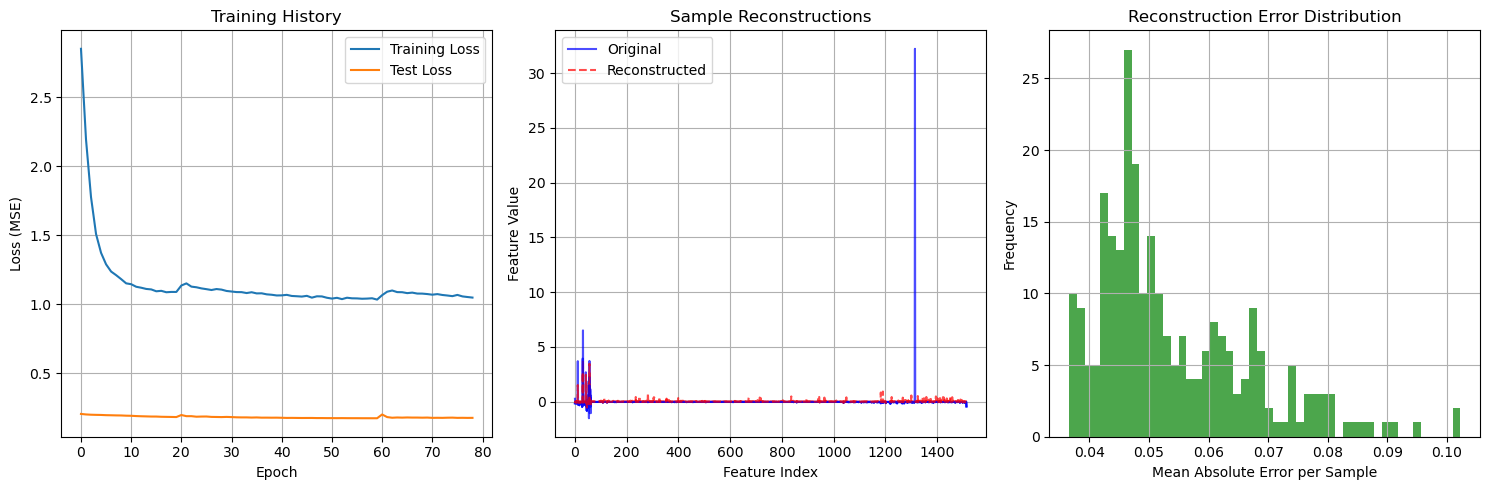


=== Compression Statistics ===
Original features: 1514
Compressed features: 64
Compression ratio: 23.66:1
Size reduction: 95.8%

⚠️ RECOMMENDATION: Autoencoder needs improvement before sales prediction
Consider: Increasing encoding_dim, more training epochs, or different architecture


In [25]:
# Cell 9: Get Reconstructions and Run Quick Diagnostic
print("\n=== Generating Reconstructions for Evaluation ===")

# Get test set reconstructions
model.eval()
test_reconstructions = []
test_originals = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        test_reconstructions.append(output.cpu().numpy())
        test_originals.append(target.numpy())

# Concatenate all batches
test_reconstructions = np.vstack(test_reconstructions)
test_originals = np.vstack(test_originals)

print(f"Reconstructions shape: {test_reconstructions.shape}")
print(f"Originals shape: {test_originals.shape}")

# Run the quick diagnostic
print("\n" + "="*60)
print("QUICK DIAGNOSTIC RESULTS")
print("="*60)

quality_metrics = calculate_quality_metrics(test_originals, test_reconstructions, X_test_selected)

# Additional visualization for quick insight
print("\n=== Quick Visualization ===")
plt.figure(figsize=(15, 5))

# Plot 1: Training history
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.grid(True)

# Plot 2: Sample reconstructions
plt.subplot(1, 3, 2)
sample_idx = np.random.randint(0, len(test_reconstructions), 3)
for i, idx in enumerate(sample_idx):
    plt.plot(test_originals[idx], 'b-', alpha=0.7, label='Original' if i == 0 else "")
    plt.plot(test_reconstructions[idx], 'r--', alpha=0.7, label='Reconstructed' if i == 0 else "")
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title('Sample Reconstructions')
plt.legend()
plt.grid(True)

# Plot 3: Error distribution
plt.subplot(1, 3, 3)
errors = np.mean(np.abs(test_reconstructions - test_originals), axis=1)
plt.hist(errors, bins=50, alpha=0.7, color='green')
plt.xlabel('Mean Absolute Error per Sample')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

# Show compression statistics
print(f"\n=== Compression Statistics ===")
print(f"Original features: {input_dim}")
print(f"Compressed features: {encoding_dim}") 
print(f"Compression ratio: {input_dim/encoding_dim:.2f}:1")
print(f"Size reduction: {(1 - encoding_dim/input_dim)*100:.1f}%")

# Check if we should proceed to sales prediction
if quality_metrics['variance_explained'] > 0.60:  # Lower threshold for book data
    print(f"\n🎯 RECOMMENDATION: Autoencoder quality is sufficient for sales prediction")
    print("Next: Use encoded features to train your sales prediction model")
else:
    print(f"\n⚠️ RECOMMENDATION: Autoencoder needs improvement before sales prediction")
    print("Consider: Increasing encoding_dim, more training epochs, or different architecture")